## 18_11_2024 Proposed

   Gender  Hemoglobin   MCH  MCHC   MCV  Result
0       1        14.9  22.7  29.1  83.7       0
1       0        15.9  25.4  28.3  72.0       0
2       0         9.0  21.5  29.6  71.2       1
3       0        14.9  16.0  31.4  87.5       0
4       1        14.7  22.0  28.2  99.5       0
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction Loss: 0.5214864863942383
Outlier Penalty: 0.9797703118298311
Silhouette Score: 0.4246461
Davies-Bouldin Index: 0.8331510389415722
S/DB Ratio: 0.5096868268712019
Hybrid Loss: 0.10977669070601948
Number of Outliers: 505
Percentage of Outliers: 35.54%
AUC Value: 1.0


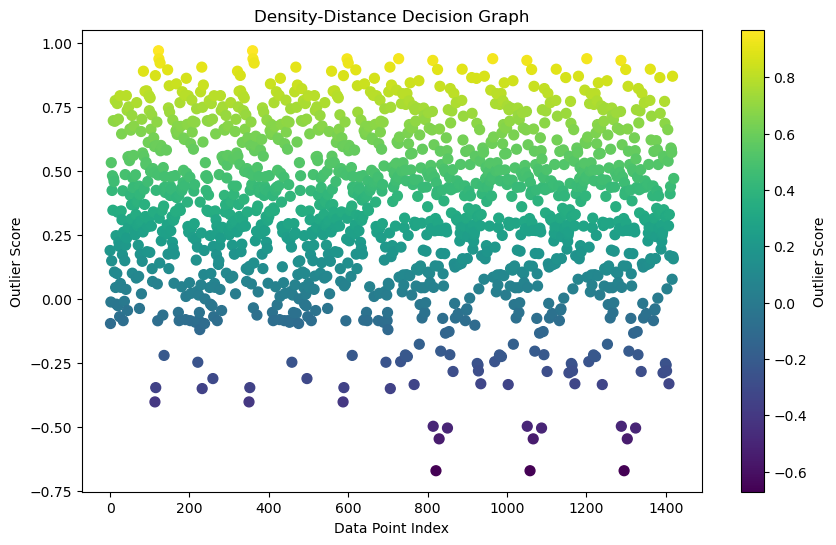

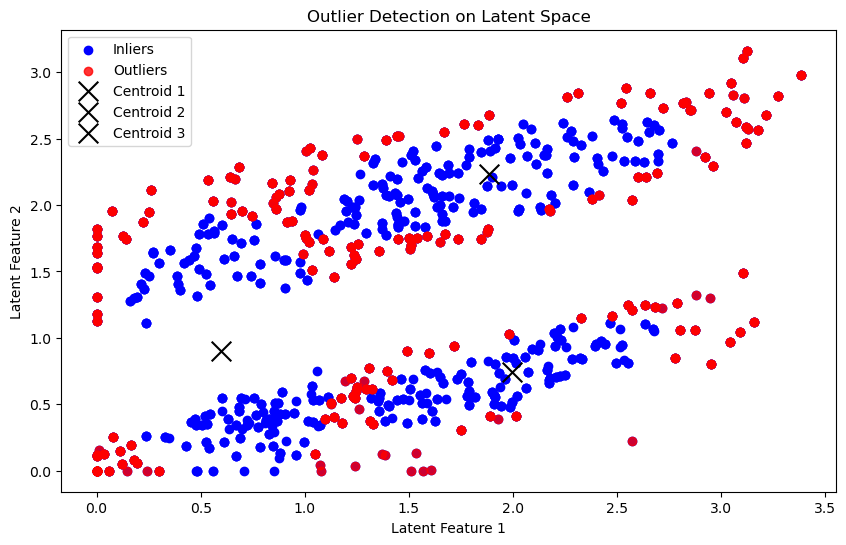

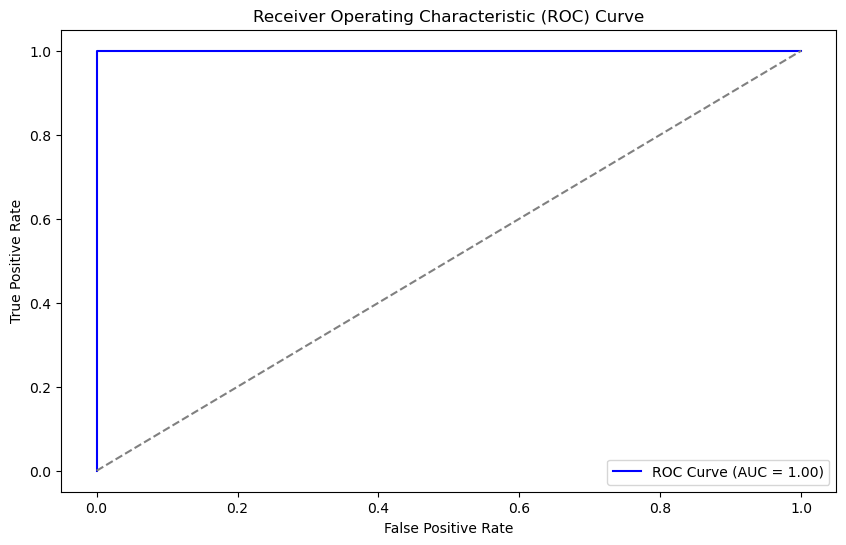

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve, auc
from scipy.spatial.distance import mahalanobis, cdist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import silhouette_samples
import seaborn as sns

file_path = r"D:\Research Related\30 Deep Robust Clustering with Mahalanobis Distance (DRCMD)\dataset\anemia.csv"
# Load the dataset into a pandas DataFrame
data = pd.read_csv(file_path)
# Display the first few rows of the dataset to understand its structure
print(data.head())
# Remove the last column
# Separate the features (X) and the target variable (y_true)
X = data.iloc[:, :-1]  # All columns except the last
y_true = data.iloc[:, -1]  # The last column

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Autoencoder model for feature extraction
input_dim = X_scaled.shape[1]
encoding_dim = 2  # Latent space dimension
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=8, verbose=0)

# Extract latent representations
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_latent = encoder_model.predict(X_scaled)

# Clustering using K-means
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X_latent)
centroids = kmeans.cluster_centers_

# Updated mahalanobis_dist function with regularization to avoid singular matrix error
def mahalanobis_dist(point, centroid, data, epsilon=1e-6):
    cov_matrix = np.cov(data, rowvar=False)
    cov_matrix += epsilon * np.eye(cov_matrix.shape[0])
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    return mahalanobis(point, centroid, inv_cov_matrix)

# Set threshold for outlier detection
threshold = 1.5  # Can be tuned based on dataset characteristics

# Identify outliers based on Mahalanobis distance
outlier_weights = []
outliers_count = 0
true_labels = []  # For AUC evaluation
predicted_scores = []  # For AUC evaluation
outliers = []

for i, point in enumerate(X_latent):
    cluster = labels[i]
    centroid = centroids[cluster]
    dist = mahalanobis_dist(point, centroid, X_latent[labels == cluster])
    is_outlier = dist > threshold
    if is_outlier:
        outliers.append(point)
    outlier_weights.append(0.5 if is_outlier else 1)
    true_labels.append(1 if is_outlier else 0)  # 1 for outliers, 0 for inliers
    predicted_scores.append(dist)  # Mahalanobis distance as anomaly score
    if is_outlier:
        outliers_count += 1

# Calculate clustering evaluation metrics
silhouette = silhouette_score(X_latent, labels)
davies_bouldin = davies_bouldin_score(X_latent, labels)
s_db_ratio = silhouette / davies_bouldin if davies_bouldin != 0 else None

# Hybrid loss calculation (including S/DB Ratio)
reconstruction_loss = np.mean(np.square(X_scaled - autoencoder.predict(X_scaled)))
outlier_penalty = np.mean([w * mahalanobis_dist(X_latent[i], centroids[labels[i]], X_latent[labels == labels[i]])
                           for i, w in enumerate(outlier_weights)])
alpha, beta = 0.1, 1  # Regularization coefficients
hybrid_loss = reconstruction_loss + alpha * outlier_penalty - beta * s_db_ratio

# Calculate AUC value
fpr, tpr, _ = roc_curve(true_labels, predicted_scores)
roc_auc = auc(fpr, tpr)

# Display results
total_points = len(X_scaled)
outliers_percentage = (outliers_count / total_points) * 100

print("Reconstruction Loss:", reconstruction_loss)
print("Outlier Penalty:", outlier_penalty)
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)
print("S/DB Ratio:", s_db_ratio)
print("Hybrid Loss:", hybrid_loss)
print("Number of Outliers:", outliers_count)
print("Percentage of Outliers:", f"{outliers_percentage:.2f}%")
print("AUC Value:", roc_auc)

# Visualization

# Density-Distance Decision Graph
outlier_scores = [
    1 - cdist([x], [centroids[np.argmin(cdist([x], centroids))]])[0, 0]
    for x in X_latent
]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(outlier_scores)), outlier_scores, c=outlier_scores, cmap='viridis', s=50)
plt.colorbar(label='Outlier Score')
plt.title('Density-Distance Decision Graph')
plt.xlabel('Data Point Index')
plt.ylabel('Outlier Score')
plt.show()

# Highlight Detected Outliers
plt.figure(figsize=(10, 6))
plt.scatter(X_latent[:, 0], X_latent[:, 1], c='blue', label='Inliers')
if len(outliers) > 0:
    outliers = np.array(outliers)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers', alpha=0.8)
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c='black', marker='x', s=200, label=f'Centroid {i+1}')
plt.title('Outlier Detection on Latent Space')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.legend()
plt.show()


# Plot ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


# 17/12/2024

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Silhouette Score: 0.769
Davies-Bouldin Index: 0.354
S/DB Ratio: 2.175
Adjusted Rand Index (ARI): 0.318
F1-Score: 0.493
Hubness Score: 18.003
AUC Value: 0.6


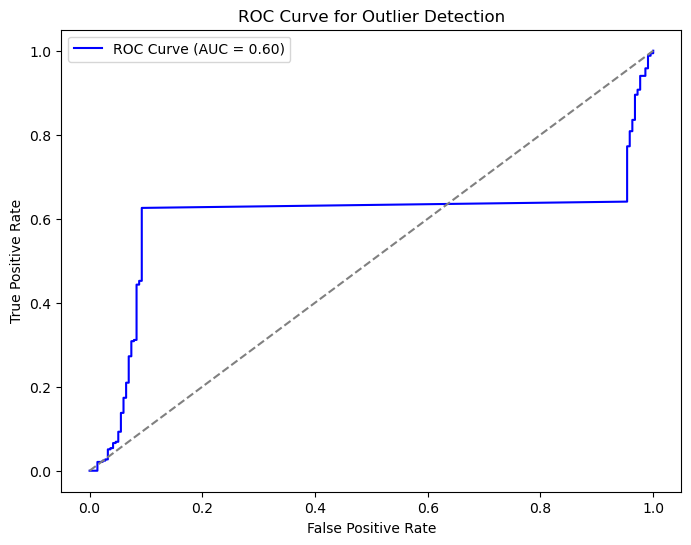

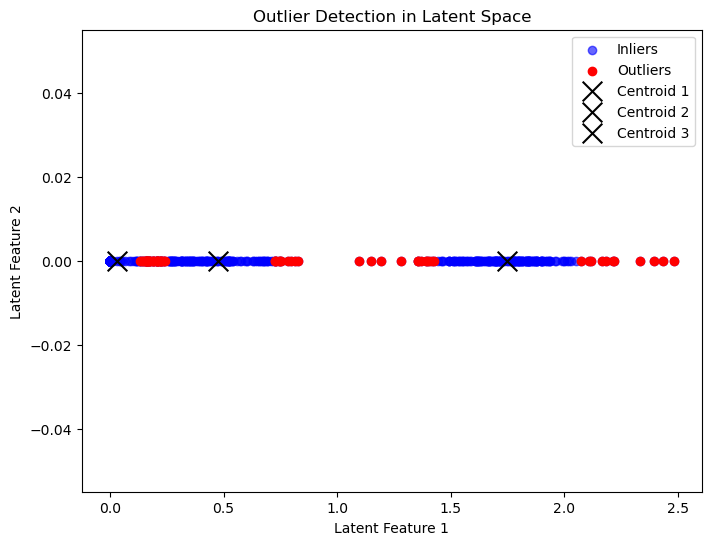

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, roc_curve, auc, adjusted_rand_score, f1_score
from scipy.spatial.distance import mahalanobis, cdist
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import silhouette_samples
import seaborn as sns

# Load the dataset
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\parkinsons.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\heart.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\hepatitis.csv" anemia
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\ionosphere.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\anemia.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn1.csv"
#file_path = r"C:\Users\psbis\2024 Clustering Autoencoder Mahalobish distance\syn2.csv"
file_path = r"2D.csv"

data = pd.read_csv(file_path) 
X = data.iloc[:, :-1]  # Features
y_true = data.iloc[:, -1]  # True labels (target)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Autoencoder for feature extraction
input_dim = X_scaled.shape[1]
encoding_dim = 2
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="linear")(encoder)
autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=8, verbose=0)

# Extract latent representations
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_latent = encoder_model.predict(X_scaled)

# K-means clustering
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X_latent)
centroids = kmeans.cluster_centers_

# Mahalanobis distance
def mahalanobis_dist(point, centroid, data, epsilon=1e-6):
    cov_matrix = np.cov(data, rowvar=False) + epsilon * np.eye(data.shape[1])
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    return mahalanobis(point, centroid, inv_cov_matrix)

threshold = 1.5
outliers = []
predicted_scores = []

# Detect outliers
for i, point in enumerate(X_latent):
    cluster = labels[i]
    centroid = centroids[cluster]
    dist = mahalanobis_dist(point, centroid, X_latent[labels == cluster])
    predicted_scores.append(dist)
    if dist > threshold:
        outliers.append(point)

# Metrics
silhouette = silhouette_score(X_latent, labels)
davies_bouldin = davies_bouldin_score(X_latent, labels)
s_db_ratio = silhouette / davies_bouldin
ari = adjusted_rand_score(y_true, labels)
f1 = f1_score(y_true, labels, average='macro')  # Assuming y_true has ground truth classes

# Hubness Score (measure of hub points in k-nearest neighbors)
def hubness_score(X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    indices = nbrs.kneighbors(X, return_distance=False)
    hubness = np.bincount(indices.flatten(), minlength=len(X))
    return np.std(hubness)

hub_score = hubness_score(X_latent, k=5)

# AUC for outlier detection
fpr, tpr, _ = roc_curve(y_true, predicted_scores)
roc_auc = auc(fpr, tpr)

# Results
print("Silhouette Score:", np.round(silhouette,3))
print("Davies-Bouldin Index:", np.round(davies_bouldin,3))
print("S/DB Ratio:", np.round(s_db_ratio,3))
print("Adjusted Rand Index (ARI):", np.round(ari,3))
print("F1-Score:", np.round(f1,3))
print("Hubness Score:", np.round(hub_score,3))
print("AUC Value:", np.round(roc_auc,3))

# Visualization: ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve for Outlier Detection")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Highlight Outliers in Latent Space
outliers = np.array(outliers)
plt.figure(figsize=(8, 6))
plt.scatter(X_latent[:, 0], X_latent[:, 1], c='blue', label='Inliers', alpha=0.6)
if len(outliers) > 0:
    plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
for i, centroid in enumerate(centroids):
    plt.scatter(centroid[0], centroid[1], c='black', marker='x', s=200, label=f'Centroid {i+1}')
plt.title('Outlier Detection in Latent Space')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.legend()
plt.show()


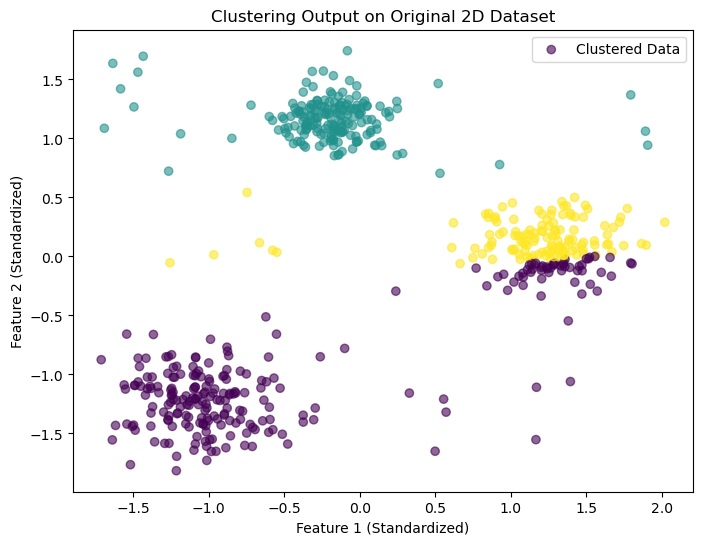

In [6]:
# Visualize Clustering on Original 2D Dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Clustered Data')
plt.title('Clustering Output on Original 2D Dataset')
plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.legend()
plt.show()